In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname,_,filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(filename)

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torchvision 
from torchvision import datasets, transforms, models
from torch import optim as optim
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import matplotlib
import matplotlib.patches as patches
import glob
import xml.etree.ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [3]:
dataset = datasets.ImageFolder('C:/Users/mcafo/Downloads/archive/images/Images/')

In [4]:
label = list(sorted(os.listdir('C:/Users/mcafo/Downloads/archive/images/Images/')))

In [5]:
list_annotations = []
list_images = []

In [6]:
for l in label:
    labels_annotation = list(sorted(os.listdir(os.path.join("C:/Users/mcafo/Downloads/archive/annotations/Annotation", l))))
    images = list(sorted(os.listdir(os.path.join('C:/Users/mcafo/Downloads/archive/images/Images', l))))
    list_annotations += labels_annotation
    list_images += images

In [7]:
class Dogs(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.img_path = "C:/Users/mcafo/Downloads/archive/images/Images/"
        self.annotation_path = "C:/Users/mcafo/Downloads/archive/annotations/Annotation/"
        self.dataset = dataset
        self.transform = transform
        
    def __getitem__(self, idx):
        image, type_  = self.dataset[idx]
 
        image = cv2.imread(self.img_path + label[type_] + "/" + list_images[idx], cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
#         image = cv2.resize(image, (256, 256), interpolation = cv2.INTER_AREA)
        image /= 255.
        
        image_id = torch.tensor([idx])
#         label_image = torch.as_tensor(type_, dtype=torch.int64).view(-1,)
        label_image = torch.ones(1, dtype=torch.int64)
        
        tree = ET.parse(self.annotation_path + label[type_] + "/" + list_annotations[idx])
        root = tree.getroot()
        boxes = []
        value = []
        for x in root[5][4][:]:
            value.append(int(x.text))
        boxes.append(value)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
            
        area = (boxes[0][3]-boxes[0][1])*(boxes[0][2]-boxes[0][0])
        area = torch.as_tensor(area, dtype=torch.float32).view(-1, )
        
        iscrowd = torch.zeros((1, ), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = label_image
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transform is not None:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': label_image
            }
            sample = self.transform(**sample)
            image = sample['image']
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
            target['boxes'] = target['boxes'].float()
        
        return image, target
    
    
    def __len__(self):
        return len(self.dataset)

In [8]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.Resize(256, 256),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 't', 'label_fields': ['labels']})

In [9]:
dog_dataset = Dogs(dataset, get_train_transform())

In [10]:
rs = dog_dataset.__getitem__(1000)

In [11]:
print(rs)

(tensor([[[0.2752, 0.2564, 0.2534,  ..., 0.0568, 0.0563, 0.0533],
         [0.2706, 0.2590, 0.2446,  ..., 0.0549, 0.0549, 0.0549],
         [0.2839, 0.2777, 0.2541,  ..., 0.0525, 0.0532, 0.0569],
         ...,
         [0.2179, 0.1966, 0.1967,  ..., 0.1004, 0.1797, 0.1270],
         [0.2106, 0.2008, 0.2069,  ..., 0.1274, 0.2105, 0.1271],
         [0.1977, 0.2218, 0.2233,  ..., 0.1343, 0.2202, 0.1368]],

        [[0.2281, 0.2093, 0.2142,  ..., 0.0568, 0.0563, 0.0533],
         [0.2236, 0.2119, 0.2053,  ..., 0.0549, 0.0549, 0.0549],
         [0.2369, 0.2306, 0.2149,  ..., 0.0525, 0.0532, 0.0569],
         ...,
         [0.1864, 0.1651, 0.1653,  ..., 0.0946, 0.1332, 0.0543],
         [0.1682, 0.1598, 0.1725,  ..., 0.1216, 0.1641, 0.0545],
         [0.1506, 0.1754, 0.1889,  ..., 0.1285, 0.1738, 0.0642]],

        [[0.1732, 0.1544, 0.1671,  ..., 0.0490, 0.0484, 0.0454],
         [0.1687, 0.1570, 0.1583,  ..., 0.0471, 0.0471, 0.0471],
         [0.1820, 0.1757, 0.1679,  ..., 0.0447, 0.0454, 0

Text(tensor(57.3440), tensor(11.4930), 'n02085782-Japanese_spaniel')

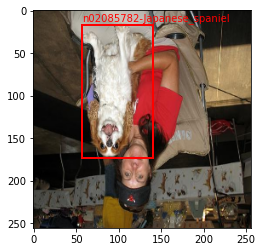

In [12]:
fig, ax = plt.subplots()
ax.imshow(rs[0].numpy().transpose(1, 2,0))
rect = patches.Rectangle((rs[1]["boxes"][0][0], rs[1]["boxes"][0][1]), (rs[1]["boxes"][0][2]-rs[1]["boxes"][0][0]), (rs[1]["boxes"][0][3]-rs[1]["boxes"][0][1]), linewidth=2, edgecolor="r", facecolor='none')
ax.add_patch(rect)
ax.text(rs[1]["boxes"][0][0], rs[1]["boxes"][0][1]-5, label[rs[1]["labels"]], color="r", fontsize=10)

In [13]:
def my_collate(batch):
    return tuple(zip(*batch))

In [14]:
dt_loader = torch.utils.data.DataLoader(dog_dataset, batch_size=32, shuffle=True, collate_fn=my_collate)

In [15]:
itr = iter(dt_loader)
imgs, targets = next(itr)
images = list(image for image in imgs)
targets = [{k: v for k, v in t.items()} for t in targets]

In [16]:
targets

[{'boxes': tensor([[ 28.6720,   2.7307, 185.3440, 256.0000]]),
  'labels': tensor([1]),
  'image_id': tensor([15092]),
  'area': tensor([113526.]),
  'iscrowd': tensor([0])},
 {'boxes': tensor([[ 93.1840,  39.5947, 222.2080, 240.9813]]),
  'labels': tensor([1]),
  'image_id': tensor([15079]),
  'area': tensor([74340.]),
  'iscrowd': tensor([0])},
 {'boxes': tensor([[ 24.0640,   0.7171, 253.4400, 238.7899]]),
  'labels': tensor([1]),
  'image_id': tensor([19580]),
  'area': tensor([148736.]),
  'iscrowd': tensor([0])},
 {'boxes': tensor([[ 55.3846,  32.0000, 167.3846, 250.6667]]),
  'labels': tensor([1]),
  'image_id': tensor([3103]),
  'area': tensor([11193.]),
  'iscrowd': tensor([0])},
 {'boxes': tensor([[  0.0000,   1.5329, 202.2400, 229.1736]]),
  'labels': tensor([1]),
  'image_id': tensor([16484]),
  'area': tensor([117315.]),
  'iscrowd': tensor([0])},
 {'boxes': tensor([[  0.0000,  54.0444, 196.2667, 247.4667]]),
  'labels': tensor([1]),
  'image_id': tensor([2750]),
  'area': 